# Selfish Agents in Networked Environments

Networked environments such as peer-to-peer networks might experience a lot of selfish agents. Selfish agents are those who do not share their resources, don't run the services they are assigned to, but rather use them to their advantage. 
Freeriders can be present on multiple levels, for example, on the level of message exchange - receving a message but not sharing it with others.

In this notebook, we will explore the problem of selfish agents in peer-to-peer networks.
We showcase the effect of selfish agents on the delivery of messages.

## Experiment Set 1

**Context**: Exchanging the transactions and data, such that every peer receives it. 

**Examples**: Any gossip network or DHT 


### Process and plan 

- Create an overlay with a peers distributed over the network:
    * *Unstructured*: Gossip Network like in Bitcoin. 
    * *Structured*: DHT-like network with a load, like Wikiedia on IPFS.  
- Load on the peers: 
    * *Unstructured*: The load is generated from the clients. Message load follow Pareto law. Each peer must spread the transactions evenly.  
    * *Structured*: clients generate load by requesting files. Peer store the files unevenly but relay the traffic. Search in DHT using the Zipf law distribution 
    
    
#### Attack scenarios 

- Model one freerider: See the effect of the freeriding on one peer. How much you can save while not losing the priority?;
- Model K freeriders: What is the effect on the whole system. How does it change with the increase in freeriders?;



## Experiment 1. A: Push-Based Gossip with Selfish Nodes

In [122]:
from p2psimpy.services import GossipService, BaseConnectionManager, MessageProducer
from p2psimpy.config import PeerType, Config
from p2psimpy.simulation import Simulation

from common import Locations, PeerConfig, prepare_topology, visualize_peer_client_network

import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns


# Configuration used for our GossipService
class GossipConfig(Config):
    exclude_types={'client',}

# Selfish gossip agent
class SelfishGossip(GossipService):
    def handle_message(self, msg):
        # Store message localy
        self._store_message(msg)
        # Don't share with other peers

# We have not two types of nodes: *peer* and *client*
def prepare_peer_types():
    return { 'peer': PeerType(PeerConfig,    {BaseConnectionManager: None, GossipService: GossipConfig}),
             'client': PeerType(PeerConfig,  [BaseConnectionManager, MessageProducer]),
             'selfish': PeerType(PeerConfig, [BaseConnectionManager, SelfishGossip])
            }


In [129]:
def experiment(N=25, S=0, C=1, T=None, G=None):
    # 1. Run the simulation 
    if not G:
        G = prepare_topology(num_peers=N, frac_selfish=S, num_clients=C)
    if not T: 
        T = prepare_peer_types()
    sim = Simulation(Locations, G, T)
    sim.run(11_000)

    # print('Nnodes number', sim.current_topology(include_bootstrap_peers=True).number_of_nodes())

    # 2. Determine the peers with furthest distance from the client
    vals = nx.shortest_path_length(G, N+1)
    max_keys = [key for key, value in vals.items() if value == max(vals.values())]

    # 3. Calculate the hit ratio of messages 
    total_msgs = len(sim.peers[N+1].get_value('msg_data'))
    return sum([len(sim.peers[k].get_value('msg_data'))/total_msgs for k in max_keys])/len(max_keys)


In [ ]:
res = {}

In [126]:
K = 200
for k in range(10,25):
    res[k] = [experiment(S=k) for _ in range(K)]

In [127]:
import itertools
peers_keys = [[k]*K for k in res.keys()]
new_res = {'peers': list(itertools.chain(*peers_keys)) , 'values': list(itertools.chain(*res.values()))}

n_df = pd.DataFrame(new_res)
n_df['peers'] = n_df['peers']/25

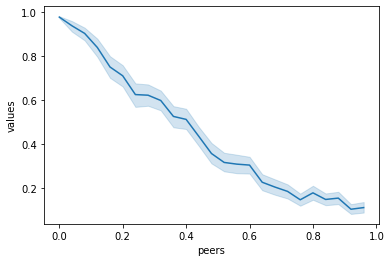

In [128]:
sns.lineplot(x='peers', y='values', data=n_df);

### Experiment 1 B: Pull-Based Gossip with Selfish Nodes

Run the same experiment but now peers run the gossip protocol in a pull-based manner.

In [ ]:
from p2psimpy.services import PullGossipService
from p2psimpy.messages import *

class SelfishPullGossip(PullGossipService):
    
    def handle_message(self, msg):
        if type(msg) == MsgRequest:
            # Ignore message requests
            pass 
        else:
            super().handle_message(msg)

NT = { 
    'peer': PeerType(PeerConfig, {BaseConnectionManager: None, PullGossipService: GossipConfig}),
    'client': PeerType(PeerConfig,  [BaseConnectionManager, MessageProducer]),
    'selfish': PeerType(PeerConfig, {BaseConnectionManager: None, SelfishPullGossip: GossipConfig})
    }

K = 100
res = {}
for k in range(0,25):
    res[k] = [experiment(S=k, T=NT) for _ in range(K)]


In [133]:
import itertools
peers_keys = [[k]*K for k in res.keys()]
new_res = {'peers': list(itertools.chain(*peers_keys)) , 'values': list(itertools.chain(*res.values()))}

n_df = pd.DataFrame(new_res)
n_df['peers'] = n_df['peers']/25

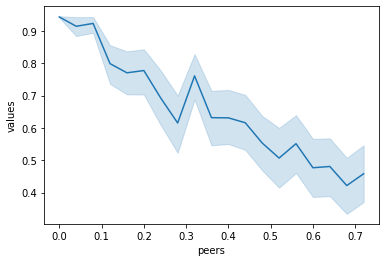

In [134]:
sns.lineplot(x='peers', y='values', data=n_df);